In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

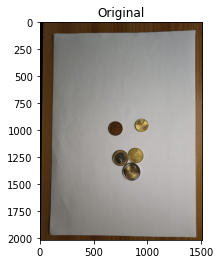

In [16]:
# First read the image
image = cv2.imread("images/juntas.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title('Original')
plt.show()

In [17]:
grayImage = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
corners = cv2.goodFeaturesToTrack(grayImage, 4, 0.01, 300)
print("1: ",corners, np.shape(corners))

corners = np.int0(corners)
print("2: ",corners, np.shape(corners))
print("3: ",np.concatenate(corners).tolist())

corners = sorted(np.concatenate(corners).tolist())
print("4: ",corners, np.shape(corners))

1:  [[[ 789. 1245.]]

 [[ 917.  924.]]

 [[1439.   78.]]

 [[ 538.  926.]]] (4, 1, 2)
2:  [[[ 789 1245]]

 [[ 917  924]]

 [[1439   78]]

 [[ 538  926]]] (4, 1, 2)
3:  [[789, 1245], [917, 924], [1439, 78], [538, 926]]
4:  [[538, 926], [789, 1245], [917, 924], [1439, 78]] (4, 2)



Corners:

A : [538, 926]
B : [789, 1245]
C : [917, 924]
D : [1439, 78]


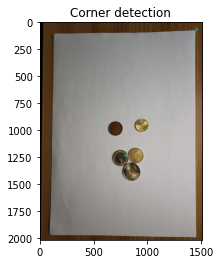

In [18]:
print("\nCorners:\n")
drawing = image.copy()

for i, c in enumerate(corners):
    x, y = c
    cv2.circle(drawing, (x,y), 3, 255, -1)
    character = chr(65 + i)
    print(character, ':', c)
    cv2.putText(drawing, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

plt.imshow(drawing)
plt.title('Corner detection')
plt.show()

# We can see that it does not work correctly


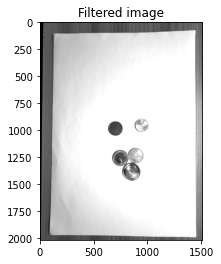

In [19]:
kernel = np.ones((5,5), np.float32) / 15
filteredImage = cv2.filter2D(grayImage,-1, kernel)
plt.imshow(cv2.cvtColor(filteredImage,cv2.COLOR_BGR2RGB))
plt.title('Filtered image')
plt.show()

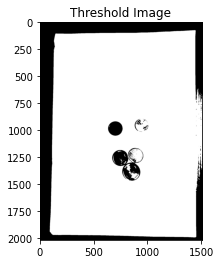

In [20]:
# Apply threshold

ret, thresImage = cv2.threshold(filteredImage,250,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#thresImage = cv2.adaptiveThreshold(filteredImage,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
plt.imshow(cv2.cvtColor(thresImage, cv2.COLOR_BGR2RGB))
plt.title('Threshold Image')
plt.show()

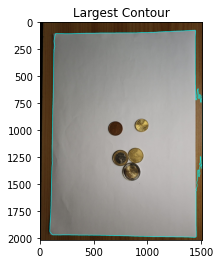

In [21]:
contours, hier = cv2.findContours(thresImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]
canvas = image.copy()
cv2.drawContours(canvas, cnt, -1, (0, 255, 255), 3)
plt.title('Largest Contour')
plt.imshow(canvas)
plt.show()

In [22]:
# Corner detection
epsilon = 0.02 * cv2.arcLength(cnt, True)
approx_corners = cv2.approxPolyDP(cnt, epsilon, True)
cv2.drawContours(canvas, approx_corners, -1, (255, 255, 0), 10)
approx_corners = sorted(np.concatenate(approx_corners).tolist())

approx_corners = [approx_corners[i] for i in [1, 0, 3, 2]] 
#[1, 0, 3, 2]
#[1, 2, 0, 3]
print(approx_corners)




[[142, 108], [115, 1967], [1445, 1985], [1437, 76]]


In [23]:
# Sort corners TL - TR - BL - BR
top_corners = approx_corners
top_corners.sort(key=lambda y:y[1])
top_corners = top_corners[0:2] 
top_corners.sort() # Top corners by order of X coord

bot_corners = approx_corners
bot_corners.sort(key=lambda y:y[1])
bot_corners = bot_corners[2:4] 
bot_corners.sort() # Bot corners by order of Y coord

print('Top corners: ', top_corners)
print('Bottom corners: ', bot_corners)

ordered_corners = top_corners + bot_corners
print('Ordered corners: ', ordered_corners)

Top corners:  [[142, 108], [1437, 76]]
Bottom corners:  [[115, 1967], [1445, 1985]]
Ordered corners:  [[142, 108], [1437, 76], [115, 1967], [1445, 1985]]



The corner points are ...

A : [142, 108]
B : [1437, 76]
C : [115, 1967]
D : [1445, 1985]


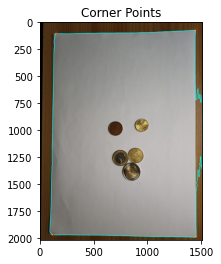

In [24]:
print('\nThe corner points are ...\n')
for index, c in enumerate(ordered_corners):
    character = chr(65 + index)
    print(character, ':', c)
    cv2.putText(canvas, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

# Rearranging the order of the corner points


plt.imshow(canvas)
plt.title('Corner Points')
plt.show()

In [25]:
def get_destination_points(corners, scale):
    """
    -Get destination points from corners of warped images
    -Approximating height and width of the rectangle: we take maximum of the 2 widths and 2 heights
    Args:
        corners: list
    Returns:
        destination_corners: list
        height: int
        width: int
    """

    w = int(21 * scale)
    h = int(29.7 * scale)

    w1 = np.sqrt((corners[0][0] - corners[1][0]) ** 2 + (corners[0][1] - corners[1][1]) ** 2)
    w2 = np.sqrt((corners[2][0] - corners[3][0]) ** 2 + (corners[2][1] - corners[3][1]) ** 2)
    #w = max(int(w1), int(w2))

    h1 = np.sqrt((corners[0][0] - corners[2][0]) ** 2 + (corners[0][1] - corners[2][1]) ** 2)
    h2 = np.sqrt((corners[1][0] - corners[3][0]) ** 2 + (corners[1][1] - corners[3][1]) ** 2)
    #h = max(int(h1), int(h2))

    destination_corners = np.float32([(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)])
    
    print('\nThe destination points are: \n')
    for index, c in enumerate(destination_corners):
        character = chr(65 + index) + "'"
        print(character, ':', c)
        
    print('\nThe approximated height and width of the original image is: \n', (h, w))
    return destination_corners, h, w

In [26]:
def unwarp(img, src, dst, wr, hr):
    """
    Args:
        img: np.array
        src: list
        dst: list
    Returns:
        un_warped: np.array
    """
    h, w = img.shape[:2]
    H, _ = cv2.findHomography(src, dst, method=cv2.RANSAC, ransacReprojThreshold=3.0)
    print('\nThe homography matrix is: \n', H)
    un_warped = cv2.warpPerspective(img, H, (wr, hr), flags=cv2.INTER_LINEAR)

    # plot

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    # f.subplots_adjust(hspace=.2, wspace=.05)
    ax1.imshow(img)
    ax1.set_title('Original Image')

    x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
    y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]

    ax2.imshow(img)
    ax2.plot(x, y, color='yellow', linewidth=3)
    ax2.set_ylim([h, 0])
    ax2.set_xlim([0, w])
    ax2.set_title('Target Area')

    plt.show()
    return un_warped


The destination points are: 

A' : [0. 0.]
B' : [6299.    0.]
C' : [   0. 8909.]
D' : [6299. 8909.]

The approximated height and width of the original image is: 
 (8910, 6300)
[[   0.    0.]
 [6299.    0.]
 [   0. 8909.]
 [6299. 8909.]]
[[ 142.  108.]
 [1437.   76.]
 [ 115. 1967.]
 [1445. 1985.]]

The homography matrix is: 
 [[ 5.01835956e+00  7.28863411e-02 -7.20478783e+02]
 [ 1.22204004e-01  4.94544329e+00 -5.51460844e+02]
 [ 2.10290410e-05  1.48216469e-05  1.00000000e+00]]


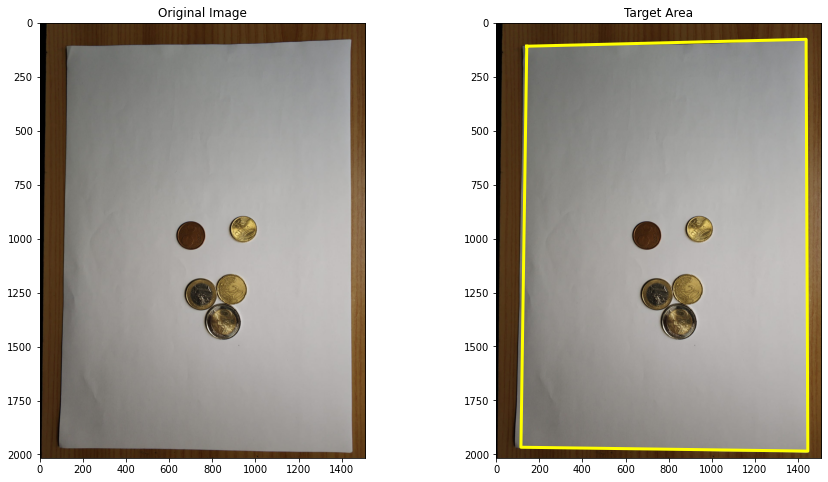

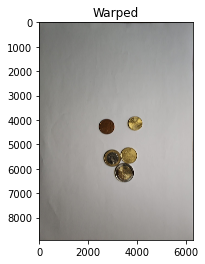

In [27]:
dst, h, w = get_destination_points(ordered_corners, 300)
srcP = np.float32(ordered_corners)
dstP = dst

print(dstP)
print(srcP)

cloneIm = image.copy()
unwarped = unwarp(cloneIm, srcP, dstP,w,h)
plt.imshow(unwarped)
plt.title('Warped')
plt.show()